## Step 1: Installations

In [1]:
!pip install /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
!pip install /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl

Processing /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
autograd is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
Processing /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
  Preparing metadata (setup.py) ... done
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=0b1318162f61d6a71396bc82922067073b5ea1ae995b222c6d436493ef5536e8
  Stored in directory: /root/.cache/pip/wheels/6b/b5/e0/4c79e15c0b5f2c15ecf613c720bb20daab20a666eb67135155
Successfully built autograd-gamma
Processing /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl


## Step 2: Imports

In [2]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
from scipy.stats import rankdata 
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold


from catboost import CatBoostRegressor, CatBoostClassifier
import catboost as cb
print("Using CatBoost version",cb.__version__)

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

Using CatBoost version 1.2.7


## Step 2: Read the data

In [3]:
test = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/test.csv")
print("Test shape:", test.shape )

train = pd.read_excel("/kaggle/input/cibmtr-2024-dataset/random_folding.xlsx")
print("Train shape:",train.shape)
train.head()

Test shape: (3, 58)
Train shape: (28800, 61)


,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time,fold
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,Bone marrow,No,No,No,IEA,6.0,+/+,NaN,2.0,NaN,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2016,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,9.942,2.0,FKalone,No,M-F,2.0,More than one race,0.0,90.0,No,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0,42.356,3
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,No,No,No,AML,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,PB,Intermediate,MAC,Not Hispanic or Latino,2008,No,Positive,No,Permissive,2.0,No,72.29,No,2.0,No,43.705,2.0,Other GVHD Prophylaxis,No,F-F,2.0,Asian,3.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1,4.672,7
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,HIS,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2019,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,33.997,2.0,Cyclophosphamide alone,No,F-M,2.0,More than one race,0.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0,19.793,6
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,ALL,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,Intermediate,MAC,Not Hispanic or Latino,2009,No,Positive,No,Permissive,2.0,No,29.23,No,2.0,No,43.245,2.0,FK+ MMF +- others,No,M-M,2.0,White,0.0,90.0,Yes,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0,102.349,1
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,No,No,No,MPN,6.0,+/+,10.0,2.0,NaN,5.0,2.0,No,2.0,2.0,PB,NaN,MAC,Hispanic or Latino,2018,No,NaN,Yes,NaN,2.0,No,56.81,No,2.0,No,29.740,2.0,TDEPLETION +- other,No,M-F,2.0,American Indian or Alaska Native,1.0,90.0,No,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0,16.223,4


## Step 4: Traget preparation

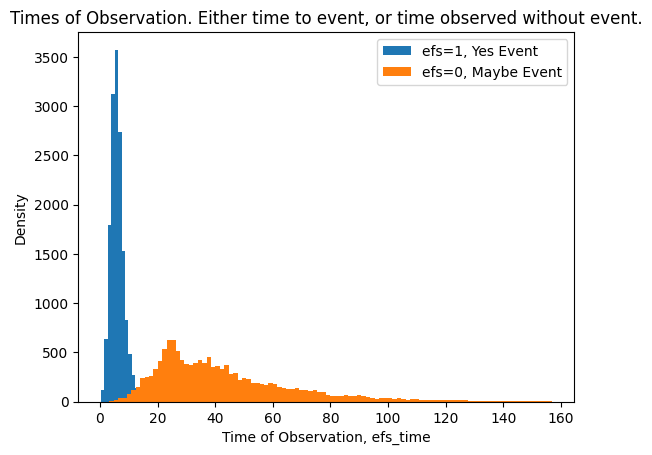

In [4]:
plt.hist(train.loc[train.efs==1,"efs_time"],bins=100,label="efs=1, Yes Event")
plt.hist(train.loc[train.efs==0,"efs_time"],bins=100,label="efs=0, Maybe Event")
plt.xlabel("Time of Observation, efs_time")
plt.ylabel("Density")
plt.title("Times of Observation. Either time to event, or time observed without event.")
plt.legend()
plt.show()

## Step 5: Features preparation

In [5]:
RMV = ["ID","efs","efs_time","target3","fold"]
FEATURES = [c for c in train.columns if not c in RMV]
print(f"There are {len(FEATURES)} FEATURES: {FEATURES}")

There are 57 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10']


In [6]:
CATS = []
for c in FEATURES:
    if train[c].dtype=="object":
        CATS.append(c)
        train[c] = train[c].fillna("NAN")
        test[c] = test[c].fillna("NAN")
    else:
        train[c] = train[c].fillna(0)
        test[c] = test[c].fillna(0)
print(f"In these features, there are {len(CATS)} CATEGORICAL FEATURES: {CATS}")

In these features, there are 35 CATEGORICAL FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'tbi_status', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'cmv_status', 'tce_imm_match', 'rituximab', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match', 'race_group', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'cardiac', 'pulm_moderate']


In [7]:
combined = pd.concat([train,test],axis=0,ignore_index=True)
#print("Combined data shape:", combined.shape )

# LABEL ENCODE CATEGORICAL FEATURES
print("We LABEL ENCODE the CATEGORICAL FEATURES: ",end="")
for c in FEATURES:

    # LABEL ENCODE CATEGORICAL AND CONVERT TO INT32 CATEGORY
    if c in CATS:
        print(f"{c}, ",end="")
        combined[c],_ = combined[c].factorize()
        combined[c] -= combined[c].min()
        combined[c] = combined[c].astype("int32")
        combined[c] = combined[c].astype("category")
        
    # REDUCE PRECISION OF NUMERICAL TO 32BIT TO SAVE MEMORY
    else:
        if combined[c].dtype=="float64":
            combined[c] = combined[c].astype("float32")
        if combined[c].dtype=="int64":
            combined[c] = combined[c].astype("int32")
    
train = combined.iloc[:len(train)].copy()
test  = combined.iloc[len(train):].reset_index(drop=True).copy()

We LABEL ENCODE the CATEGORICAL FEATURES: dri_score, psych_disturb, cyto_score, diabetes, tbi_status, arrhythmia, graft_type, vent_hist, renal_issue, pulm_severe, prim_disease_hct, cmv_status, tce_imm_match, rituximab, prod_type, cyto_score_detail, conditioning_intensity, ethnicity, obesity, mrd_hct, in_vivo_tcd, tce_match, hepatic_severe, prior_tumor, peptic_ulcer, gvhd_proph, rheum_issue, sex_match, race_group, hepatic_mild, tce_div_match, donor_related, melphalan_dose, cardiac, pulm_moderate, 

In [8]:
FOLDS = 10
oof_preds = np.zeros(len(train))

#data = pd.get_dummies(train, columns=CATS, drop_first=True).drop('ID', axis=1)
for fold in range(FOLDS):

    train_data = train[train['fold']!=fold]
    valid_data = train[train['fold']==fold]

    # Drop constant columns if they exist
    train_data = train_data.loc[:, train_data.nunique() > 1]
    valid_data = valid_data[train_data.columns]

    cph = CoxPHFitter(penalizer=0.01)
    cph.fit(train_data, duration_col='efs_time', event_col='efs')
    
    oof_preds[valid_data.index] = cph.predict_partial_hazard(valid_data)              

train['y'] = oof_preds 

## Step 6: Model training

In [9]:
FOLDS = 10
oof_cat_cox = np.zeros(len(train))
pred_cat_cox = np.zeros(len(test))

models = {}

for fold in range(FOLDS):

    print("#"*25)
    print(f"### Fold {fold+1}")
    print("#"*25)

    x_train = train[train['fold']!=fold][FEATURES].copy()
    y_train = train[train['fold']!=fold]["y"].copy()
    x_valid = train[train['fold']==fold][FEATURES].copy()
    y_valid = train[train['fold']==fold]["y"].copy()
    x_test  = test[FEATURES].copy()

    model_cat_cox = CatBoostRegressor(
        loss_function= "RMSE",
        learning_rate= 0.03,
        random_state= 42,
        task_type= 'CPU',
        num_trees= 6000,
        reg_lambda= 8.0,
        depth= 8,
        subsample=0.85,
        early_stopping_rounds=300,
        verbose=0,
        cat_features=CATS
    )
    model_cat_cox.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=CATS,
              verbose=100)

    # INFER OOF
    oof_cat_cox[x_valid.index] = model_cat_cox.predict(x_valid)
    # INFER TEST
    pred_cat_cox += model_cat_cox.predict(x_test)
    models[fold]     = model_cat_cox

# COMPUTE AVERAGE TEST PREDS
pred_cat_cox /= FOLDS

#########################
### Fold 1
#########################
0:	learn: 0.5941982	test: 0.6074298	best: 0.6074298 (0)	total: 197ms	remaining: 19m 40s
100:	learn: 0.2438293	test: 0.2514883	best: 0.2514883 (100)	total: 13.7s	remaining: 13m 21s
200:	learn: 0.1834525	test: 0.1935002	best: 0.1935002 (200)	total: 28.6s	remaining: 13m 45s
300:	learn: 0.1521242	test: 0.1659540	best: 0.1659540 (300)	total: 43s	remaining: 13m 34s
400:	learn: 0.1301673	test: 0.1473817	best: 0.1473817 (400)	total: 58.1s	remaining: 13m 30s
500:	learn: 0.1149915	test: 0.1348107	best: 0.1348107 (500)	total: 1m 12s	remaining: 13m 16s
600:	learn: 0.1065767	test: 0.1274692	best: 0.1274692 (600)	total: 1m 26s	remaining: 12m 53s
700:	learn: 0.0986924	test: 0.1211284	best: 0.1211284 (700)	total: 1m 40s	remaining: 12m 39s
800:	learn: 0.0912501	test: 0.1152174	best: 0.1152174 (800)	total: 1m 54s	remaining: 12m 25s
900:	learn: 0.0851599	test: 0.1102367	best: 0.1102367 (900)	total: 2m 9s	remaining: 12m 14s
1000:	learn: 0.0795

## Step 7: Model score 

In [10]:
"""
To evaluate the equitable prediction of transplant survival outcomes,
we use the concordance index (C-index) between a series of event
times and a predicted score across each race group.
 
It represents the global assessment of the model discrimination power:
this is the model’s ability to correctly provide a reliable ranking
of the survival times based on the individual risk scores.
 
The concordance index is a value between 0 and 1 where:
 
0.5 is the expected result from random predictions,
1.0 is perfect concordance (with no censoring, otherwise <1.0),
0.0 is perfect anti-concordance (with no censoring, otherwise >0.0)

"""

import pandas as pd
import pandas.api.types
import numpy as np
from lifelines.utils import concordance_index

class ParticipantVisibleError(Exception):
    pass


def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    """
    >>> import pandas as pd
    >>> row_id_column_name = "id"
    >>> y_pred = {'prediction': {0: 1.0, 1: 0.0, 2: 1.0}}
    >>> y_pred = pd.DataFrame(y_pred)
    >>> y_pred.insert(0, row_id_column_name, range(len(y_pred)))
    >>> y_true = { 'efs': {0: 1.0, 1: 0.0, 2: 0.0}, 'efs_time': {0: 25.1234,1: 250.1234,2: 2500.1234}, 'race_group': {0: 'race_group_1', 1: 'race_group_1', 2: 'race_group_1'}}
    >>> y_true = pd.DataFrame(y_true)
    >>> y_true.insert(0, row_id_column_name, range(len(y_true)))
    >>> score(y_true.copy(), y_pred.copy(), row_id_column_name)
    0.75
    """
    
    del solution[row_id_column_name]
    del submission[row_id_column_name]
    
    event_label      = 'efs'
    interval_label   = 'efs_time'
    prediction_label = 'predictions'
    for col in submission.columns:
        if not pandas.api.types.is_numeric_dtype(submission[col]):
            raise ParticipantVisibleError(f'Submission column {col} must be a number')
            
    # Merging solution and submission dfs on ID
    merged_df           = pd.concat([solution, submission], axis=1)
    merged_df.reset_index(inplace=True)
    merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)
    
    metric_list         = []
    for race in merged_df_race_dict.keys():
        # Retrieving values from y_test based on index
        indices        = sorted(merged_df_race_dict[race])
        merged_df_race = merged_df.iloc[indices]
        
        # Calculate the concordance index
        c_index_race   = concordance_index(
                            merged_df_race[interval_label],
                            -merged_df_race[prediction_label],
                            merged_df_race[event_label])
        
        metric_list.append(c_index_race)
    return float(np.mean(metric_list)-np.sqrt(np.var(metric_list)))

## Step 8: Model CV

In [11]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["predictions"] = oof_cat_cox
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost KaplanMeier =",m)

<ipython-input-10-461dcbfea217>:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for CatBoost KaplanMeier = 0.6228381497451487


## Step 9: Create submission.csv

In [12]:
sub = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv")
sub.prediction = rankdata(pred_cat_cox) 
sub.to_csv("submission.csv",index=False)
print("Sub shape:",sub.shape)
sub.head()

Sub shape: (3, 2)


,ID,prediction
0,28800,2.0
1,28801,3.0
2,28802,1.0


## Step 10: Save the models

In [13]:
import pickle
with open('catboost_exp_04.pkl', 'wb') as f:
    pickle.dump(models, f)

In [14]:
train['predictions'] = oof_cat_cox
train.to_excel("catboost_exp_04_oof.xlsx")

In [15]:
train

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time,fold,y,predictions
0,0,0,0,0,0,0.0,0.0,0,0,6.0,0,0,0,0,0,6.0,0,0.0,2.0,0,6.0,2.0,0,2.0,2.0,0,0,0,0,2016,0,0,0,0,2.0,0,0.000000,0,2.0,0,9.942000,2.0,0,0,0,2.0,0,0.0,90.0,0,0,0,0,8.0,0,2.0,0,10.0,0.0,42.356,3.0,0.449514,0.442892
1,1,1,0,1,0,2.0,8.0,1,0,6.0,1,0,0,0,1,6.0,0,10.0,2.0,1,6.0,2.0,0,2.0,2.0,1,1,1,0,2008,0,1,1,1,2.0,0,72.290001,0,2.0,0,43.705002,2.0,1,0,1,2.0,1,3.0,90.0,0,1,1,0,8.0,0,2.0,1,10.0,1.0,4.672,7.0,1.994081,1.938980
2,2,0,0,0,0,2.0,8.0,0,0,6.0,0,0,0,0,2,6.0,0,10.0,2.0,1,6.0,2.0,0,2.0,2.0,0,0,0,0,2019,0,0,0,0,2.0,0,0.000000,0,2.0,0,33.997002,2.0,2,0,2,2.0,0,0.0,90.0,0,1,1,0,8.0,0,2.0,0,10.0,0.0,19.793,6.0,0.329416,0.348897
3,3,2,0,1,0,2.0,8.0,0,0,6.0,0,0,0,0,3,6.0,0,10.0,2.0,1,6.0,2.0,0,2.0,2.0,0,1,1,0,2009,0,1,1,1,2.0,0,29.230000,0,2.0,0,43.244999,2.0,3,0,3,2.0,2,0.0,90.0,1,1,0,0,8.0,0,2.0,0,10.0,0.0,102.349,1.0,0.964914,0.952129
4,4,2,0,0,0,2.0,8.0,0,0,6.0,1,0,0,0,4,6.0,0,10.0,2.0,0,5.0,2.0,0,2.0,2.0,1,0,1,1,2018,0,0,0,0,2.0,0,56.810001,0,2.0,0,29.740000,2.0,4,0,0,2.0,3,1.0,90.0,0,1,1,1,8.0,0,2.0,0,10.0,0.0,16.223,4.0,0.731165,0.727907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28795,28795,7,3,4,0,2.0,8.0,0,0,6.0,1,0,0,2,3,6.0,2,10.0,2.0,1,6.0,2.0,0,2.0,2.0,1,1,1,0,2018,0,2,0,3,2.0,0,24.212000,1,2.0,0,51.136002,2.0,7,1,0,2.0,0,0.0,0.0,2,4,3,0,8.0,3,2.0,0,10.0,0.0,18.633,4.0,0.626794,0.764689
28796,28796,2,0,2,1,1.0,4.0,0,0,5.0,1,0,0,0,1,3.0,1,6.0,2.0,4,4.0,1.0,0,2.0,2.0,1,2,2,1,2017,0,1,1,0,1.0,0,30.770000,0,1.0,0,18.075001,2.0,8,0,0,1.0,4,3.0,90.0,0,2,1,0,6.0,1,1.0,1,8.0,1.0,4.892,9.0,1.115446,1.177149
28797,28797,6,3,2,3,2.0,8.0,0,2,6.0,1,0,1,2,9,6.0,1,10.0,2.0,4,6.0,2.0,1,2.0,2.0,1,3,1,0,2018,0,0,1,4,2.0,0,22.627001,0,2.0,1,51.005001,2.0,3,1,0,2.0,4,5.0,90.0,2,2,0,0,8.0,3,2.0,0,10.0,0.0,23.157,2.0,2.533072,2.468625
28798,28798,0,0,2,0,1.0,4.0,0,0,3.0,1,0,1,2,9,3.0,0,5.0,1.0,1,3.0,1.0,0,1.0,1.0,1,0,3,0,2018,2,0,0,0,1.0,0,58.074001,1,1.0,1,0.044000,1.0,2,0,3,1.0,5,1.0,90.0,0,1,1,1,4.0,0,1.0,0,5.0,0.0,52.351,9.0,0.811894,0.813713
